In [48]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from datetime import datetime

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [6]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

#### load in catalog and match with C20

In [18]:
# the output catalogs (from graham)
name_tag = '_08squdeg'
detect_limit = '_nolimit'
nz_prior = '_nz_prior'
sfq_added = '_sfq_added'
cat_output_nonir_name = graham_output_dir+'pcat_cat_out'+name_tag+'_nonir_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
print(cat_output_nonir_name)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass_sfq_added.fits


In [19]:
cat_output_name = cat_output_nonir_name
cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
combined_cat_name = cat_output_name.replace('_sfq_added.fits','c20added.fits')

col_list = "'RA DEC MASS_MED ZPHOT sfq_nuvrk'"
cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
   in1='+cat_output_name+' values1="RA DEC" \
   in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
   in3=/Users/lejay/research/massive_gals/clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits values3="RA DEC" \
   out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
# print(cmd)
os.system(cmd)

cat_original = Table.read(cat_output_name)
cat_matched = Table.read(combined_cat_name)
arr,ind = np.unique(cat_matched['STRING_INPUT'],return_index=True)
cat_matched = cat_matched[ind]
cat_matched = cat_matched[cat_matched['MAG_AUTO_CH1_CORR']<99]
cat_matched = cat_matched[cat_matched['MAG_AUTO_CH2_CORR']<99]
cat_matched = cat_matched[cat_matched['lp_zPDF_1']>0]
cat_matched = cat_matched[~np.isnan(cat_matched['lp_mass_med_1'])]

max_phot_err = 0.15
cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < max_phot_err) )| \
         ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < max_phot_err) )
cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < max_phot_err) ) 
cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < max_phot_err) )
cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < max_phot_err) )
cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < max_phot_err) )
cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < max_phot_err) )
flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)
cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < max_phot_err) )
cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < max_phot_err) )
cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < max_phot_err) )
cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < max_phot_err) )
flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)
cond_ch1 = ( (cat_matched['MAG_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH1_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] < 0.5) )
cond_ch2 = ( (cat_matched['MAG_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH2_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] < 0.5) )
flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 

flag_list = [flag_optical,flag_nir,flag_irac,flag_nir]
flag_name_list = ['flag_optical','flag_nir','flag_irac','flag_nir']
    
if len(cat_matched) != len(flag_optical) or len(cat_matched) != len(flag_nir) or len(cat_matched) != len(flag_irac):
    print('lengths do not match')
else:

    print(cat_output_name)
    print(len(cat_matched),'/',len(cat_original))
    col_flag_optical = Column(name='flag_optical', data=flag_optical)
    col_flag_nir = Column(name='flag_nir', data=flag_nir)
    col_flag_irac = Column(name='flag_irac', data=flag_irac)
    col_log_ezmass = Column(name='log_ez_mass_p500', data=np.log10(cat_matched['ez_mass_p500_1']))
    if 'flag_optical' in cat_matched.keys():
        cat_matched.remove_column('flag_optical')
    if 'flag_nir' in cat_matched.keys():
        cat_matched.remove_column('flag_nir')
    if 'flag_irac' in cat_matched.keys():
        cat_matched.remove_column('flag_irac')
    if 'log_ez_mass_p500' in cat_matched.keys():
        cat_matched.remove_column('log_ez_mass_p500')
        
    cat_matched.add_columns([col_flag_optical, col_flag_nir, col_flag_irac,col_log_ezmass])
    cat_matched.rename_column('lp_zPDF_1','lp_zPDF')
    cat_matched.rename_column('lp_mass_med_1','lp_mass_med')
    cat_matched.rename_column('ez_mass_p500_1','ez_mass_p500')
    cat_matched.rename_column('flag_photoz_1','flag_photoz')
    cat_matched.rename_column('MASS_MED_1','MASS_MED_massrun')
    cat_matched.write(combined_cat_name, overwrite=True)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass_sfq_added.fits
193170 / 212186


#### redshift checks with C20

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass_sfq_added.fits


Text(0.02, 0.84, '$\\eta=$1.1\\% (17333), $\\sigma_{NMAD}=0.067$')

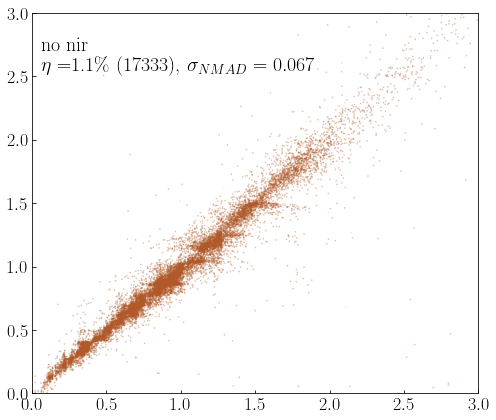

In [49]:
# redshift comparison

sfq = 'all'
z_keyname = 'Z_COMBINE'

cat_name = cat_output_nonir_name
print(cat_name)
cat_output_c20added = Table.read(cat_name.replace('_sfq_added.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]

flag_photoz = cat_output_c20added['flag_photoz']==1  # internally consistent photoz within C20 catalog
flag_optical = cat_output_c20added['flag_optical'] 
flag_irac = cat_output_c20added['flag_irac'] 
flag_nir = cat_output_c20added['flag_nir'] 

# only show galaxies with good photo
cond_filters = (flag_optical>2) & (flag_irac>=1)

# COSMOS consistent photoz objects only
cond = flag_photoz & cond_filters
        
fig, axs = plt.subplots(1, 1, figsize = (8, 7))
plt.scatter(cat_output_c20added[cond]['lp_zPDF'], cat_output_c20added[cond][z_keyname],s=0.5,c=flag_filter[cond],alpha=0.3,cmap='Paired')
plt.xlim([0,3])
plt.ylim([0,3])

# print out outlier fraction
outlier_factor = 0.15
num_outliers_15 = len(cat_output_c20added[cond][abs(cat_output_c20added[cond]['lp_zPDF']-cat_output_c20added[cond][z_keyname])>outlier_factor*(1+cat_output_c20added[cond]['lp_zPDF'])])
deltaz = np.array(cat_output_c20added[cond]['Z_ML']-cat_output_c20added[cond]['lp_zPDF'])
sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
plt.annotate('no nir',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
plt.annotate('$\eta=$'+str(round(num_outliers_15/len(cat_output_c20added[cond])*100,1))+'\% '+'('+str(len(flag_filter[cond]))+'), $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')

#### Mass check with C20

#### z-corrections

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass_sfq_added.fits
0.2
0.5
0.8
1.1


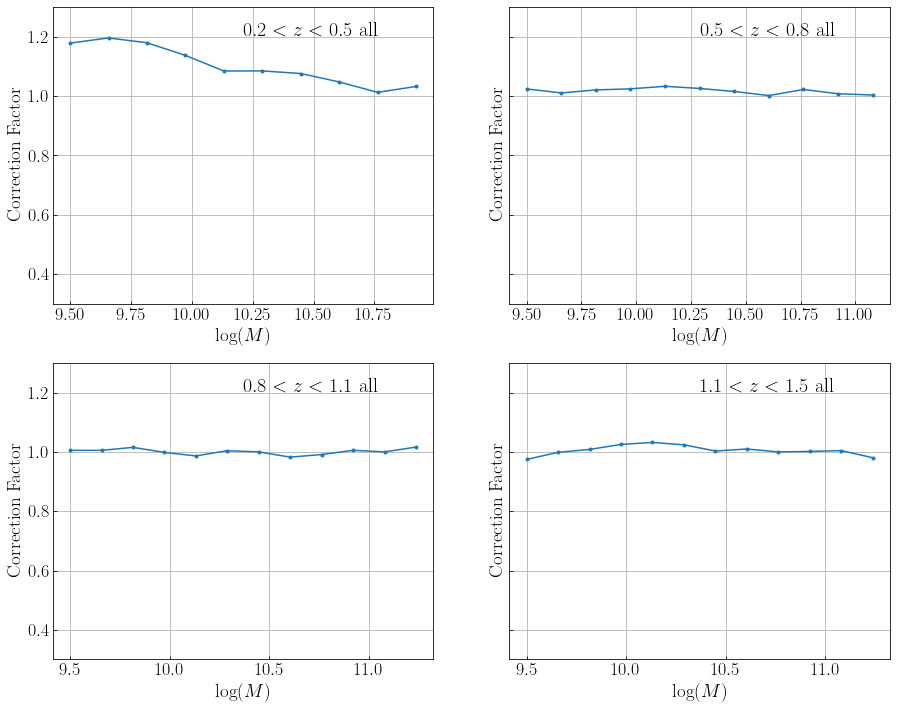

In [44]:
# outlier correction for number density
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
sfq = 'all'
zkeyname = 'Z_COMBINE'

cat_name = cat_output_nonir_name
print(cat_name)
cat_output_c20added = Table.read(cat_name.replace('_sfq_added.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]

# remove N/A's from PDZ list
pdz_list = []
pdz_flag = []
for gal in cat_output_c20added:
    if "N/A" not in gal['pdz']:
        pdz = np.array(gal['pdz'].split(',')).astype(float)
        pdz_list.append(pdz)
        pdz_flag.append(True)
    else:
        pdz_flag.append(False)
        
# peaky_check = []
# for i,gal in enumerate(cat_output_c20added):
#     pdz = pdz_list[i]
#     pdz_zbins = np.linspace(0,6,len(pdz))
    
#     #trim the non zeros in pdz
#     pdz_zbins_trim = pdz_zbins[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
#     pdz_trim = pdz[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
#     if len(pdz_trim[pdz_trim>0.25*np.max(pdz_trim)])<=2:
#         peaky_check.append(1) # peaky
#     else:
#         peaky_check.append(0) # non-peaky
        
flag_photoz = cat_output_c20added['flag_photoz']==1  # internally consistent photoz within C20 catalog
flag_optical = cat_output_c20added['flag_optical'] 
cond_filters = (flag_optical>3) #& (peaky_check==0)
cat_output_c20added = cat_output_c20added[flag_photoz & cond_filters]

if sfq == 'q':
    cat_output_c20added = cat_output_c20added[cat_output_c20added['sfq_nuvrk']==0]
elif sfq == 'sf':
    cat_output_c20added = cat_output_c20added[cat_output_c20added['sfq_nuvrk']==1]
else:
    pass

fig, axs = plt.subplots(2, 2, figsize = (15, 12), sharey=True)
mass_list = np.linspace(9.5, 12.5, 20)
min_gals = 200 # minimum number of galaxies in the bin to have a measurement
bin_size = 0.125
mode = 'failures only' # 'all_outliers' or 'failures_only'
if mode == 'failures only':
    threshold = 0.1
    mode_show = mode + '('+ str(threshold) + ')'
else:
    threshold = ''
    mode_show = mode
    
time = datetime.now()
time = time.strftime("%y-%m-%d %H:%M")
#plt.suptitle('mode:'+mode_show+', bin size:'+str(bin_size)+', min. gals in bin:'+str(min_gals)+'\n'+time,fontsize=20)

for i in range(len(z_mins)):
    row = i//2
    col = i % 2
    mass_plot_list = []
    correction_list = []
    print(z_mins[i])
    for mass in mass_list:
        cond = abs(cat_output_c20added['MASS_MED_massrun']-mass)<bin_size
        cat_m_select = cat_output_c20added[cond]
        
        cat_true = cat_m_select[np.logical_and(cat_m_select['lp_zPDF']>z_mins[i],cat_m_select['lp_zPDF']<z_maxs[i])]
        cat_my_z = cat_m_select[np.logical_and(cat_m_select[zkeyname]>z_mins[i],cat_m_select[zkeyname]<z_maxs[i])]
        
        cat_correct = cat_my_z[np.logical_and(cat_my_z['lp_zPDF']>z_mins[i],cat_my_z['lp_zPDF']<z_maxs[i])]
        cat_interlopers = cat_my_z[abs(cat_my_z['lp_zPDF']-cat_my_z[zkeyname])>threshold*(1+cat_my_z[zkeyname])]
        cat_missing = cat_true[abs(cat_true['lp_zPDF']-cat_true[zkeyname])>threshold*(1+cat_true['lp_zPDF'])]
        cat_outliers = cat_true[abs(cat_true['lp_zPDF'] - cat_true[zkeyname])>threshold*(1+cat_true['lp_zPDF'])]
        
        if len(cat_true)>min_gals or len(cat_my_z)>min_gals:
            mass_plot_list.append(mass)
            if mode == 'all outliers':
                correction_list.append(len(cat_true)/len(cat_my_z))
            else:
                correction_list.append((len(cat_correct)+len(cat_missing))/(len(cat_correct)+len(cat_interlopers)))

    axs[row][col].plot(mass_plot_list,correction_list,'.-')
    axs[row][col].set_xlabel(r'$\log(M)$',fontsize=19)
    axs[row][col].set_ylabel('Correction Factor',fontsize=19)
    axs[row][col].grid(True)
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$ '+sfq,xy=([0.5,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[row][col].set_ylim([0.3,1.3])
    
    # save to disc
    corr_factor = np.vstack([mass_plot_list,np.array(correction_list)])
    np.save('pcat_outlier_corr_frac_'+sfq+'_'+str(z_mins[i])+'.npy',corr_factor)
    
    # fit polynomial
    # coeff = np.polyfit(mass_plot_list,correction_list,3)
    # x_corr = np.linspace(mass_plot_list[0],mass_plot_list[-1],100)
    # y_corr = coeff[0]*x_corr**3+coeff[1]*x_corr**2+coeff[2]*x_corr+coeff[3]
    # axs[row][col].plot(x_corr, y_corr, color='r',alpha=0.5)
    # corr_factor_smooth = np.vstack([x_corr,y_corr])
    # np.save('pcat_outlier_corr_frac_'+sfq+'_'+str(z_mins[i])+'_smooth.npy',corr_factor_smooth)
    

#### mass corrections

In [31]:
def percentile_16(arr):
    return np.percentile(arr,16)

def percentile_84(arr):
    return np.percentile(arr,84)

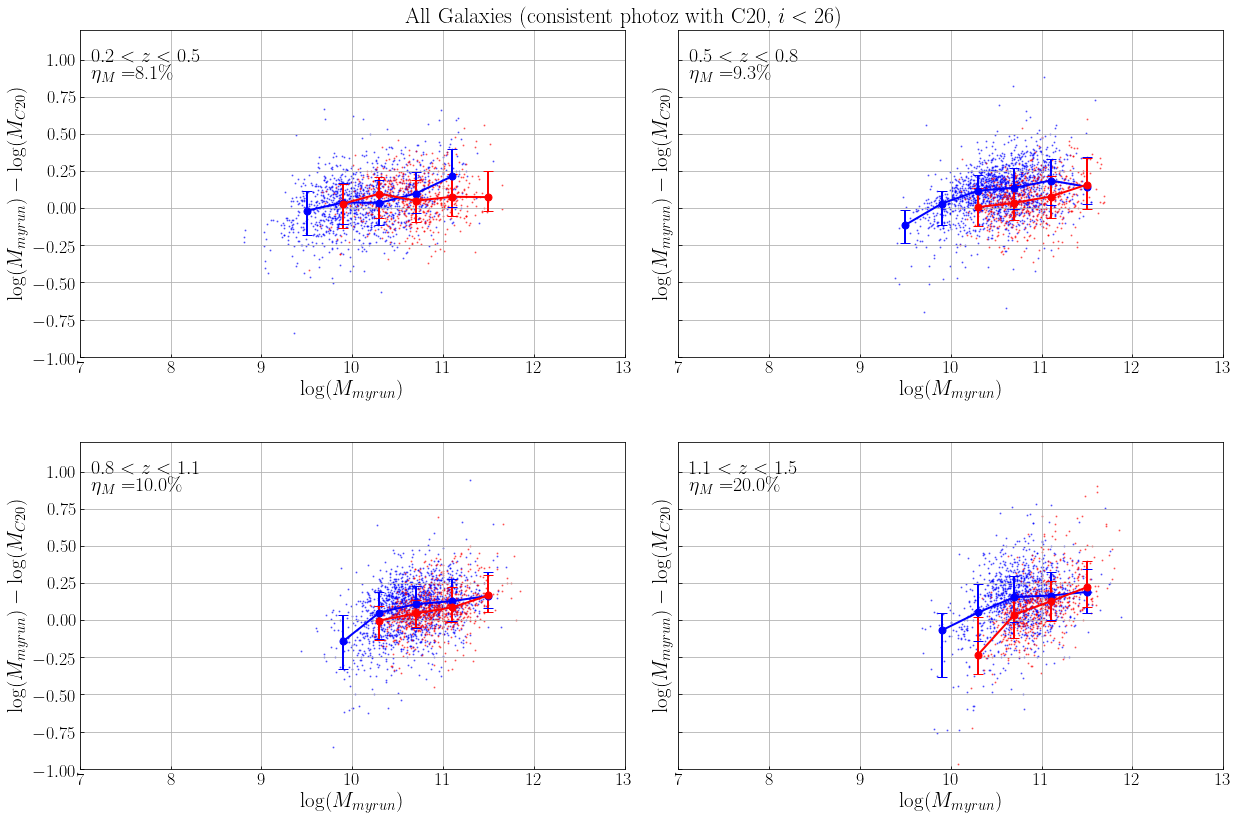

In [45]:
fig, axs = plt.subplots(2, 2, figsize = (18, 12), sharey=True)
cat_output_c20added = Table.read(cat_name.replace('_sfq_added.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
sfq_show = 'split' # 'all' or 'split'
zkeyname = 'Z_COMBINE'

for i,z_min in enumerate(z_mins):
    row = i // 2; col = i % 2
    cat_z = cat_output_c20added[cat_output_c20added[zkeyname]>z_mins[i]]
    cat_z = cat_z[cat_z[zkeyname]<z_maxs[i]]
    flag_photoz = cat_z['flag_photoz']==1  
    fig_title = 'All Galaxies (consistent photoz with C20, $i<26$)'
    
    flag_optical = cat_z['flag_optical'] 
    flag_irac = cat_z['flag_irac'] 
        
    # only show galaxies with good photo
    cond_filters = (flag_optical>3) & (flag_irac>=2)
            
    # COSMOS consistent photoz objects only
    cond_photoz_match = abs(cat_z[zkeyname] - cat_z['lp_zPDF'])<0.15*(1+cat_z['lp_zPDF'])
    cond =  cond_filters & flag_photoz & cond_photoz_match
    cat_z = cat_z[cond]
    
    if sfq_show == 'split':
        colors = ['b','r']
        for k,sfq in enumerate(['sf','q']):
            if sfq == 'q':
                cat_tmp = cat_z[cat_z['sfq_nuvrk_myrun_free']==0]
            else:
                cat_tmp = cat_z[cat_z['sfq_nuvrk_myrun_free']==1]
       
            # data to plot
            x = np.array(cat_tmp['MASS_MED_massrun'])
            y = np.array(cat_tmp['MASS_MED_massrun'] - cat_tmp['lp_mass_med'])
            y[np.isnan(y)]=-99
            y_massive_gal = y[cat_tmp['MASS_MED_massrun']>11.2]
    
            # plot
            im = axs[row][col].scatter(x,y,s=1,c=colors[k],alpha=0.5)
    
            # running median
            step=0.4
            counts,bin_edges,bin_numbers = binned_statistic(x, y, statistic='count', bins=np.arange(9.3,12.2,step))
            medians,bin_edges,bin_numbers = binned_statistic(x, y, statistic='median', bins=np.arange(9.3,12.2,step))
            per16,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_16, bins=np.arange(9.3,12.2,step))
            per84,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_84, bins=np.arange(9.3,12.2,step))
            
            bin_centers = bin_edges[:-1]+step/2
            medians = medians[counts>10]
            bin_centers = bin_centers[counts>10]
            per16 = per16[counts>10]
            per84 = per84[counts>10]
            axs[row][col].errorbar(bin_centers, medians, yerr=[medians-per16,per84-medians],fmt='o-',color=colors[k],linewidth=2,capsize=5,markersize=7)
            np.save('mass_err/mass_err_median_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i]),np.array((bin_centers,medians,(per84-per16)/2)))
    
    else:
        # data to plot
        cat_tmp = cat_z
        x = np.array(cat_tmp['MASS_MED_massrun'])
        y = np.array(cat_tmp['MASS_MED_massrun'] - cat_tmp['lp_mass_med'])
        y[np.isnan(y)]=-99
        y_massive_gal = y[cat_tmp['MASS_MED_massrun']>11.2]
    
        # plot
        im = axs[row][col].scatter(x,y,s=1,c='k',alpha=0.5)
    
        # running median
        step=0.4
        counts,bin_edges,bin_numbers = binned_statistic(x, y, statistic='count', bins=np.arange(9.3,12.2,step))
        medians,bin_edges,bin_numbers = binned_statistic(x, y, statistic='median', bins=np.arange(8.5,12.2,step))
        per16,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_16, bins=np.arange(8.5,12.2,step))
        per84,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_84, bins=np.arange(8.5,12.2,step))
        
        bin_centers = bin_edges[:-1]+step/2
        medians = medians[counts>10]
        bin_centers = bin_centers[counts>10]
        per16 = per16[counts>10]
        per84 = per84[counts>10]
        
        axs[row][col].errorbar(bin_centers,medians,yerr=[medians-per16,per84-medians],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
    
        # histogram for delta_M
        axs[row][col].hist(y,bins=100,range=(-1,1.2),orientation='horizontal',weights=-10*np.ones(len(y))/len(y),bottom=13,histtype='step')
        axs[row][col].hist(y_massive_gal,bins=30,range=(-1,1.2),orientation='horizontal',weights=-8*np.ones(len(y_massive_gal))/len(y_massive_gal),bottom=13,histtype='step')
        print("median dM's")
        print(str(z_mins[i])+'<z<'+str(z_maxs[i]),'dM='+str(round(np.median(y),2)),', massive dM='+str(round(np.median(y_massive_gal),2)),str(len(y_massive_gal)))
        np.save('mass_err/mass_err_median_all_'+str(z_mins[i])+'_'+str(z_maxs[i]),np.array((bin_edges[:-1]+step/2,medians,(per84-per16)/2)))
    
    axs[row][col].set_xlabel(r'$\log(M_{myrun})$',fontsize=21)
    axs[row][col].set_ylabel(r'$\log(M_{myrun}) - \log(M_{C20})$',fontsize=21)
    axs[row][col].set_xlim([7,13])
    axs[row][col].set_ylim([-1,1.2])
    axs[row][col].grid()
        
    # print out mass outlier fraction
    outlier_factor = 0.3
    num_outliers = len(cat_z[abs(cat_z['MASS_MED_massrun'] - cat_z['lp_mass_med'])>outlier_factor])
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[row][col].annotate('$\eta_{M}=$'+str(round(num_outliers/len(cat_z)*100,1))+'\% ',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
     
    # cbar = fig.colorbar(im, ax=axs[row][col])
    # cbar.ax.set_ylabel(flag_name_list[i],fontsize=19)
    
plt.suptitle(fig_title,fontsize=22)
plt.tight_layout(pad=4, w_pad=2)

#### correct for Galactic extinction

In [1]:
from __future__ import print_function
import astropy.units as units
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

In [17]:
# u, uS, g, r, i, z, y
coef = [4.1382,4.008,3.2582,2.2864,1.6412,1.2641,1.0808]

for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
    print(cat_name)
    cat = Table.read('/Volumes/LejaySSD/phosphorus_catalogs/p_cats_v211221/'+cat_name+'_pcat211221_mags_gals_CH1_CH2.fits')
    for i,band in enumerate(['u','uS','g','r','i','z','y']):
        coords = SkyCoord(cat['RA']*units.deg,  cat['DEC']*units.deg)
        ebv = sfd(coords)
        corr  = coef[i]*ebv
        cat[band] = cat[band] - corr
        
    # save the extinction correted catalog with a different name
    cat.write('/Volumes/LejaySSD/phosphorus_catalogs/p_cats_v211221/'+cat_name+'_pcat_mags_gals_CH1_CH2_extinction_corrected.fits', overwrite=True)

COSMOS_deep
DEEP_deep
ELAIS_deep
